# Marginal plots

In [1]:
import sumProduct as sp
import numpy as np
import matplotlib.pyplot as plt
import scipy.special
import scipy.stats
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter, MaxNLocator
import subprocess
import graphviz as gp

In [2]:
vlist=['H'+str(i) for i in range(20)]
hidden=[sp.variableNode(name, vrange=['pain', 'nopain']) for name in vlist]
Slist=['S'+str(i) for i in range(20)]
sensory=[sp.variableNode(name, vrange=['tickle','noci']) for name in Slist]
variables=sensory+hidden
len(variables)
factors=[]

In [3]:
prior=sp.freeEnergyFactorNode()
prior.addNeighbour(hidden[0])

def exprior(condrv,conditioners):
    if condrv[0] is None:
        return 100.0
    if condrv[0]=='nopain':
        return 0.2
    if condrv[0]=='pain':
        return 0.8
    
prior.setPrior(exprior)
factors.append(prior)
prior.predictFactor()

In [4]:
def hiddenprior(condrv,conditioners):
    if condrv[0] is None:
        return 100.0
    if conditioners[0]=='pain':
        if condrv[0]=='pain':
            return 0.8
        if condrv[0]=='nopain':
            return 0.2
    else:
        if condrv[0]=='pain':
            return 0.6
        if condrv[0]=='nopain':
            return 0.4

In [5]:
parent=hidden[0]
hiddenfactors=[]
for child in hidden[1:]:
    fe=sp.freeEnergyFactorNode()
    fe.addNeighbour(child,isConditioner=False)
    fe.addNeighbour(parent,isConditioner=True)
    fe.setPrior(hiddenprior)
    factors.append(fe)
    hiddenfactors.append(fe)
    parent=child
    fe.predictFactor()
print(len(factors))
print(len(hiddenfactors))

20
19


In [6]:
def sensprior(condrv,conditioners):
    if condrv[0] is None:
        return 50.0
    if conditioners[0]=='pain':
        if condrv[0]=='noci':
            return 0.6
        if condrv[0]=='tickle':
            return 0.4
    else:
        if condrv[0]=='tickle':
            return 0.6
        if condrv[0]=='noci':
            return 0.4

In [7]:
sensfactors=[]
for h,s in zip(hidden,sensory):
    f=sp.freeEnergyFactorNode()
    f.addNeighbour(s)
    f.addNeighbour(h,isConditioner=True)
    f.setPrior(sensprior)
    factors+=[f]
    sensfactors+=[f]
    f.predictFactor()
    
allNodes=variables+factors

In [8]:
pnopain={}
ppain={} 
pseudocounts=[]

sp.startLearning(allNodes)
for trial in range(40):
#     for i in sensory[0:5]:
#         i.observe('noci')
#         sp.runSumProduct(allNodes)
#     for a in sensory[12:18]:
#         a.observe('tickle')
    for t in range(1):
        for s in sensory:
            s.observe('tickle')
    sp.runSumProduct(allNodes)
    sp.runSumProduct(allNodes)       
    sp.accumulateEvidence(allNodes)
    sp.learn(allNodes)
# Create dictionaries where nodename, trial --> marginals of hidden
    for node in hidden: 
        pnopain[int(node.name[1:]),trial]=[node.marginal()[0]['nopain']]
        ppain[int(node.name[1:]),trial]=[node.marginal()[0]['pain']]

starting learning for 80 nodes
Runing Sum-product
Runing Sum-product
accumulating evidence for 80 nodes
learning for 80 nodes
Runing Sum-product
Runing Sum-product
accumulating evidence for 80 nodes
learning for 80 nodes
Runing Sum-product
Runing Sum-product
accumulating evidence for 80 nodes
learning for 80 nodes
Runing Sum-product
Runing Sum-product
accumulating evidence for 80 nodes
learning for 80 nodes
Runing Sum-product
Runing Sum-product
accumulating evidence for 80 nodes
learning for 80 nodes
Runing Sum-product
Runing Sum-product
accumulating evidence for 80 nodes
learning for 80 nodes
Runing Sum-product
Runing Sum-product
accumulating evidence for 80 nodes
learning for 80 nodes
Runing Sum-product
Runing Sum-product
accumulating evidence for 80 nodes
learning for 80 nodes
Runing Sum-product
Runing Sum-product
accumulating evidence for 80 nodes
learning for 80 nodes
Runing Sum-product
Runing Sum-product
accumulating evidence for 80 nodes
learning for 80 nodes
Runing Sum-product


In [9]:
Marginals=[]
for node in hidden: 
    Marginals.append([node.marginal()[0]['pain']])

In [10]:
HiddenPCpain=[]
HiddenPCnopain=[]
for node in hiddenfactors:
    HiddenPCpain.append(node.pseudoCounts[('pain',)])
    HiddenPCnopain.append(node.pseudoCounts[('nopain',)])

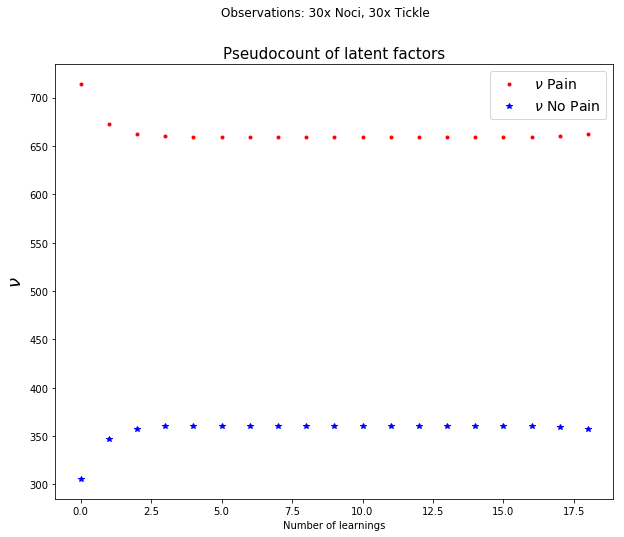

In [11]:
plt.figure(figsize=(10.0,8.0))
plt.title("Pseudocount of latent factors", fontsize=15)
plt.suptitle(r'Observations: 30x Noci, 30x Tickle')
plt.plot(HiddenPCpain, 'r.',label=r'$\nu$ Pain')
plt.plot(HiddenPCnopain, 'b*', label=r'$\nu$ No Pain')
plt.xlabel("Number of learnings")
plt.ylabel(r'$\nu$',fontsize=18)
plt.legend(fontsize=14)
plt.savefig("Latent_Prior_Pseudocount.png")
plt.show()

# Noch einmal eine längere Markov chain plotten die keine observations am Ende mehr hat

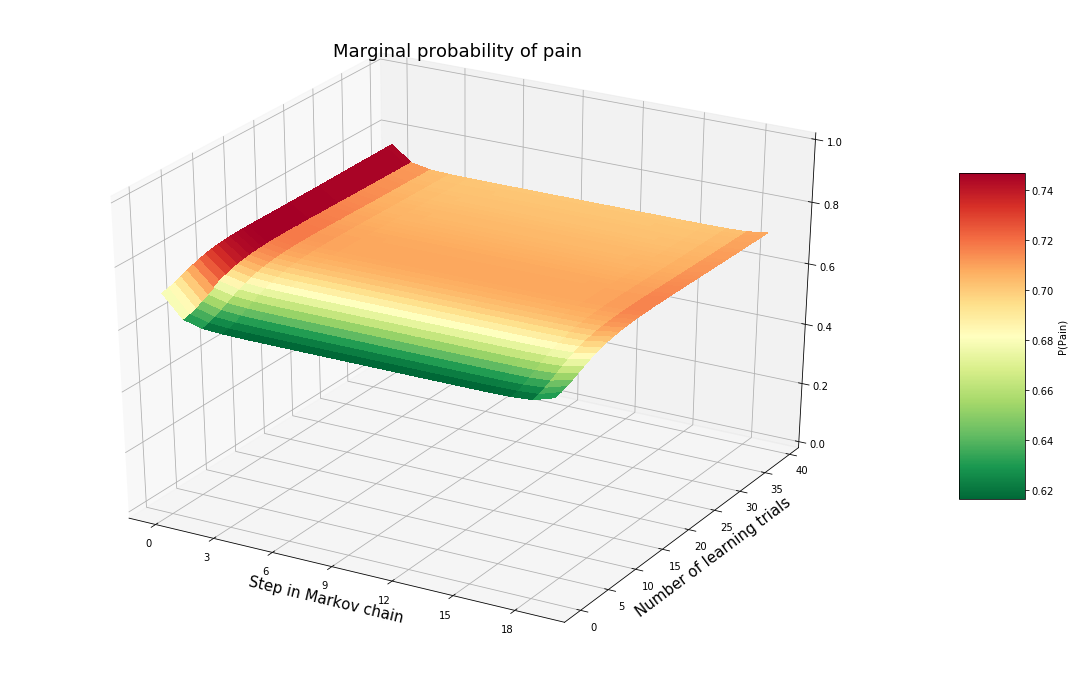

In [12]:
X = np.arange(len(Slist))
Y = np.arange(40) # NUMBER OF TRIALS NEEDS TO BE PUT HERE
X,Y = np.meshgrid(X,Y)
Z = []
for x,y in zip(X.flat,Y.flat):
    Z.append(ppain[(x,y)])
    
Z=np.array(Z).reshape(X.shape)

fig = plt.figure(figsize=(20.0,12.0))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap=cm.RdYlGn_r, linewidth=0, antialiased=False)

plt.xlabel('Step in Markov chain', fontsize=15)
plt.ylabel('Number of learning trials', fontsize=15)
plt.title('Marginal probability of pain',fontsize=18)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

axes = plt.gca()
axes.set_zlim([0.0,1])

fig.colorbar(surf, shrink=0.5, aspect=5, label='P(Pain)')
plt.savefig('marginal_pain_surf_tickletherapy.png')
plt.show()

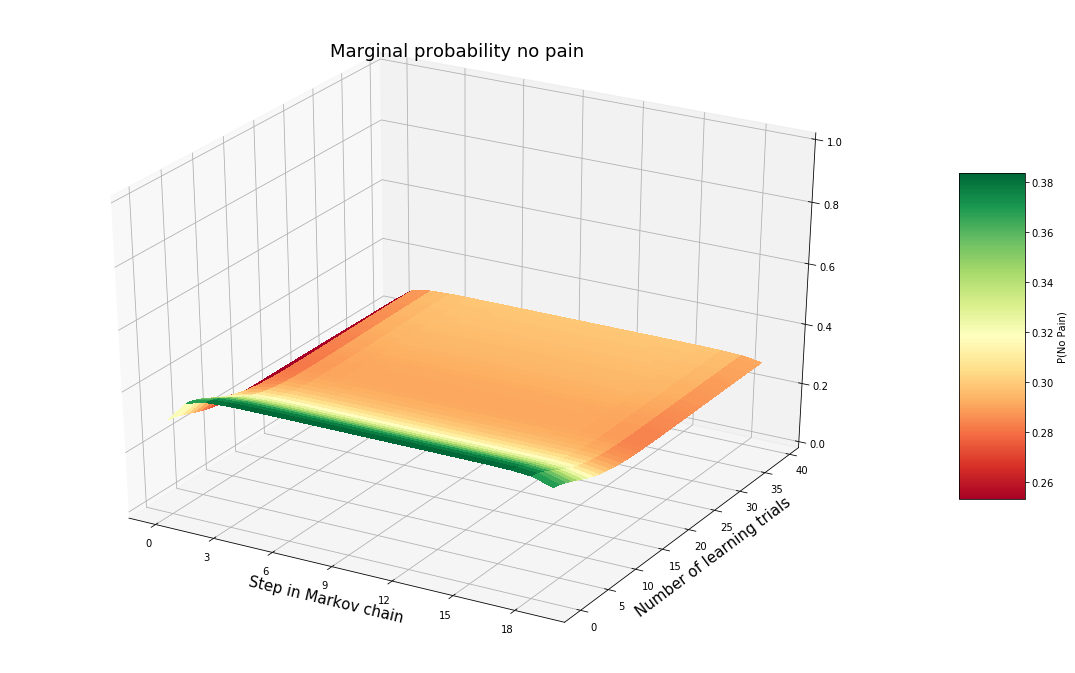

In [13]:
A = np.arange(len(Slist))
B = np.arange(40)
A,B = np.meshgrid(A,B)
C = []
for a,b in zip(A.flat,B.flat):
    C.append(pnopain[(a,b)])
    
C=np.array(C).reshape(A.shape)

fig = plt.figure(figsize=(20.0,12.0))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(A, B, C, cmap=cm.RdYlGn, linewidth=0, antialiased=False)

plt.xlabel('Step in Markov chain', fontsize=15)
plt.ylabel('Number of learning trials', fontsize=15)

plt.title('Marginal probability no pain', fontsize=18)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

axes = plt.gca()
axes.set_zlim([0.0,1])

fig.colorbar(surf, shrink=0.5, aspect=5, label='P(No Pain)')
plt.savefig('marginal_nopain_surf_tickletherapy.png')
plt.show()